CAP 5625 Computational Foundations of AI
Fall 2021 - Dr. DeGiorgio
<br>Programming Assignement 1 - Ridge regression without libraries
<br>Christian Garbin

Instructions to run the code are available in the README.md file.

# Setting up the environment

Import the Python modules we use in the notebook and configure the Jupyter environment.

In [1]:
import copy
from typing import Tuple
import numpy as np
import pandas as pd
import seaborn as sns
# Seaborn uses Matplotlib behind the scenes
%matplotlib inline

Import our ridge regression module and the utilities.

In [2]:
import utils
import ridge

Run the automated tests to verify the code works as intended before we start the expriments.

In [3]:
import test
# Set to true to see each test result
test.verbose = False
test.test_all()
print('All tests passed')

All tests passed


The range of values to try for the tunig parameter (lambda).

In [10]:
LAMBDAS_TO_TEST = [0.01, 0.1, 1, 10, 100, 1_000, 10_000]
NUM_TESTS = len(LAMBDAS_TO_TEST)

Read the dataset and prepare it by encoding categorical columns, then scaling the features (X, the input) and centering the targets (Y, the output).

From this point on, we make copies of the dataset to save time (not read from the disk multiple times.

In [11]:
_x, _y = None, None # cache the dataset
NUM_FEATURES = -1
FEATURE_NAMES = []

def read_dataset() -> Tuple[np.ndarray, np.ndarray]:
    global _x, _y, NUM_FEATURES, FEATURE_NAMES
    
    if _x is None or _y is None:
        _x, _y, FEATURE_NAMES = utils.read_dataset('Credit_N400_p9.csv')
        NUM_FEATURES = _x.shape[1]

        # Encode the categorical values
        utils.encode_binary_cateogry(_x, column=6, one_value='Female')  # gender
        utils.encode_binary_cateogry(_x, column=7, one_value='Yes')  # student
        utils.encode_binary_cateogry(_x, column=8, one_value='Yes')  # married

        utils.scale(_x)
        utils.center(_y)

    # Always return a copy to preserve the original values
    return copy.deepcopy(_x), copy.deepcopy(_y)

# Deliverable 1

> Illustrate the effect of the tuning parameter on the inferred ridge regression coefficients by generating a plot (e.g., using Excel, Matlab, R, etc.) of nine lines (one for each = 9 = of the 𝑝 features), with the 𝑦 -axis as 10𝛽 𝑗 , 𝑗 1 , 2 , … , 9, and the 𝑥-axis the corresponding . log-scaled tuning parameter value log (𝜆) that generated the particular 𝛽.

Perform ridge regression with the different lambda values.

In [12]:
def experiment1(lmbda: float) -> Tuple[np.ndarray, float]:
    x, y = read_dataset()

    model = ridge.fit(x, y, lr=0.00001, lmbda=lmbda, iterations=10_000)
    predictions = ridge.predict(x, model)
    mse = utils.mse(y, predictions)

    return model, mse

In [13]:
betas = []
for i, lmbda in enumerate(LAMBDAS_TO_TEST):
    b, _ = experiment1(lmbda)
    coef_str = ' '.join('{:8.2f}'.format(c) for c in b.flatten())
    print(f'Lambda: {lmbda} coefficients: {coef_str}')
    betas.append(b)

Lambda: 0.01 coefficients:  -274.86   329.02   286.80    19.53   -11.06    -2.88    -5.21   127.24    -4.22
Lambda: 0.1 coefficients:  -274.53   329.88   285.61    19.59   -11.09    -2.88    -5.20   127.21    -4.22
Lambda: 1 coefficients:  -271.33   325.61   286.68    19.59   -11.32    -2.82    -5.10   126.81    -4.28
Lambda: 10 coefficients:  -242.11   301.07   281.71    20.22   -13.32    -2.36    -4.19   123.16    -4.72
Lambda: 100 coefficients:   -94.64   211.37   209.55    22.36   -19.18    -0.46     0.22    97.67    -5.73
Lambda: 1000 coefficients:    22.93    84.08    84.22    10.27    -5.69    -0.10     1.99    34.00    -1.96
Lambda: 10000 coefficients:     7.31    14.44    14.47     1.50    -0.13    -0.11     0.36     4.57    -0.13


In [14]:
betas = np.squeeze(betas)

In [15]:
df = pd.DataFrame(betas, columns=FEATURE_NAMES, index=LAMBDAS_TO_TEST)

In [16]:
df

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married
0.01,-274.858216,329.019731,286.802661,19.528873,-11.064833,-2.875177,-5.207965,127.238549,-4.218608
0.10,-274.53204,329.88115,285.613361,19.585579,-11.086961,-2.875906,-5.19774,127.206854,-4.215969
1.00,-271.330484,325.607108,286.68379,19.592748,-11.31914,-2.81647,-5.097489,126.814157,-4.277692
10.00,-242.111001,301.070162,281.709703,20.223759,-13.322593,-2.35508,-4.185863,123.16118,-4.719228
100.00,-94.639427,211.365448,209.546148,22.364962,-19.175688,-0.461881,0.219414,97.667029,-5.732029
1000.00,22.933101,84.077705,84.217036,10.26565,-5.693172,-0.099719,1.9933,34.002375,-1.959075
10000.00,7.306755,14.441697,14.474018,1.50157,-0.127983,-0.114126,0.363792,4.573953,-0.134201


In [17]:
df2 = df.stack().reset_index()
df2.columns = ['Lambda', 'Feature', 'Coefficient']
df2

,Lambda,Feature,Coefficient
0,0.01,Income,-274.858216
1,0.01,Limit,329.019731
2,0.01,Rating,286.802661
3,0.01,Cards,19.528873
4,0.01,Age,-11.064833
...,...,...,...
58,10000.00,Age,-0.127983
59,10000.00,Education,-0.114126
60,10000.00,Gender,0.363792
61,10000.00,Student,4.573953


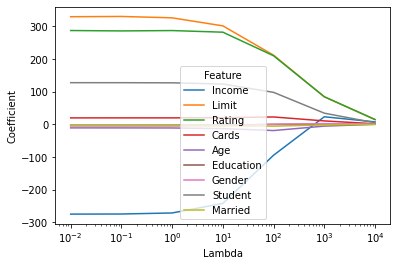

In [18]:
g = sns.lineplot(y='Coefficient', x='Lambda', hue='Feature', data=df2)
g.set_xscale('log')